# EfficientNet-B4 Classification on CIFAR-10

This notebook contains the code to train and evaluate a EfficientNet-B4 model on the CIFAR-10 dataset to compare with the Swin Transformer model. All code apart from model definition is exactly the same as the main notebook for training the Swin Transformer model.

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os

#Disable warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [3]:
# Load data
batch_size = 64
img_height = 32
img_width = 32

train_ds = tfds.load('cifar10', split='train', shuffle_files=True)
val_ds = tfds.load('cifar10', split='test', shuffle_files=False)

AUTOTUNE = tf.data.AUTOTUNE

# For EfficientNet, we dont need to rescale values as it expects (0-255)
# Add data augmentations
trainAug = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])
# For validation, we just use resize/rescale
valAug = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
])

train_ds = train_ds.map(lambda features: (trainAug(features['image']), features['label']), 
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda features: (valAug(features['image']), features['label']), 
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [4]:
images, labels = next(iter(train_ds))
print(images.shape, labels.shape)

(64, 32, 32, 3) (64,)


In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [6]:
num_batches = train_ds.reduce(0, lambda x,_: x+1).numpy()
print('# of batches in train set: ',num_batches)

# of batches in train set:  782


In [7]:
#Check GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
input_shape = (img_height, img_width, 3)

learning_rate = 1e-3
num_epochs = 35
weight_decay = 1e-5

total_steps = int(num_epochs * num_batches)

In [9]:
#Define and compile model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.applications.efficientnet.EfficientNetB4(include_top=False,weights=None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
metric1 = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
metric2 = tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top3_accuracy")

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    metrics=[metric1, metric2]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 10)                17930     
                                                                 
Total params: 17,691,753
Trainable params: 17,566,546
Non-trainable params: 125,207
_________________________________________________________________


In [10]:
%load_ext tensorboard
import datetime
from utils.callback import OneCycleScheduler

model_name = 'EfficientNetB3-cifar10'
#Callback for tensorboard logging
log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-'+model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#Callback for saving model checkpoints
checkpoint_filepath = 'model-checkpoints/Efficientnet/'+model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Define LR Scheduler (OneCycleScheduler)
lr_schedule = OneCycleScheduler(learning_rate, total_steps)

#Train model
history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[lr_schedule, tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/35
782/782 [==============================] - 109s 108ms/step - loss: 2.3962 - accuracy: 0.1296 - top3_accuracy: 0.3675 - val_loss: 2.5281 - val_accuracy: 0.1202 - val_top3_accuracy: 0.3388
Epoch 2/35
782/782 [==============================] - 79s 101ms/step - loss: 2.3144 - accuracy: 0.1442 - top3_accuracy: 0.3982 - val_loss: 2.5475 - val_accuracy: 0.1280 - val_top3_accuracy: 0.3817
Epoch 3/35
782/782 [==============================] - 78s 100ms/step - loss: 2.2469 - accuracy: 0.1628 - top3_accuracy: 0.4407 - val_loss: 2.3765 - val_accuracy: 0.1681 - val_top3_accuracy: 0.4329
Epoch 4/35
782/782 [==============================] - 79s 101ms/step - loss: 2.1809 - accuracy: 0.1846 - top3_accuracy: 0.4800 - val_loss: 2.2443 - val_accuracy: 0.2089 - val_top3_accuracy: 0.5066
Epoch 5/35
782/782 [==============================] - 82s 105ms/step - loss: 2.1084 - accuracy: 0.2099 - top3_accuracy: 0.5297 - val_loss: 2.1097 - val_accuracy: 0.2325 - val_top3_accuracy: 0.5665
Epoch 6/35
782

## Results

We observe that the EfficientNet-B4 achieves ~61.1% validation accuracy after 35 epochs. We plot accuracy curves and measure the inference time:

In [11]:
# Load Best weights
model.load_weights(checkpoint_filepath)

In [12]:
# Re-evaluate based on loaded weights
metrics = model.evaluate(val_ds, verbose=2)
print("Restored model: (loss, validation accuracy, validation top-3 accuracy)\n ",metrics)

157/157 - 3s - loss: 1.1101 - accuracy: 0.6112 - top3_accuracy: 0.8819 - 3s/epoch - 20ms/step
Restored model: (loss, validation accuracy, validation top-3 accuracy)
  [1.1100741624832153, 0.6111999750137329, 0.8819000124931335]


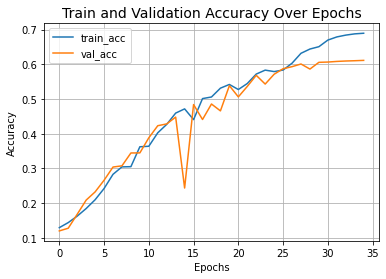

In [13]:
# Plot accuracy curve
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [21]:
# Check inference time
import time

images, labels = next(iter(val_ds))
start_time = time.time() # set the time at which inference started
model.predict(tf.expand_dims(images[0], axis=0))
stop_time = time.time()
duration = stop_time - start_time
hours = duration // 3600
minutes = (duration - (hours * 3600)) // 60
seconds = duration - ((hours * 3600) + (minutes * 60))
msg = f'training elapsed time was {seconds * 1000} ms)'
print (msg, flush=True)

1/1 [==============================] - 0s 35ms/step
training elapsed time was 67.80886650085449 ms)
